# Vector Space Word Embeddings on PubMed Psychology Abstract  
## Harry Xiong  
### Abstracts of NIH PubMed articles on psychology, behavioral science in multiple years (mainly 2019) and neural science are extracted. Data source: https://www.nlm.nih.gov/databases/download/pubmed_medline.html

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [2]:
#!pip install --user git+http://github.com/titipata/pubmed_parser.git
import pubmed_parser as pp
import nltk
from nltk.corpus import stopwords
import re
import pandas as pd

In [3]:
#newest file downloaded from PubMed website
#pubmed20n1014.xml.gz
filename = 'pubmed20n1014.xml.gz'

In [4]:
# filtering criteria: psyc-related abstract
psych_keywords = ['psych', 'behavior', 'neur']

def isPsych(abstract, keywords):
    return any(word in abstract for word in keywords)

In [5]:
pubmed_parsed = pp.parse_medline_xml("./" + 'pubmed20n1014.xml.gz')

In [6]:
pubmed_df = pd.DataFrame(pubmed_parsed)
pubmed_df.head(5)

,title,abstract,journal,authors,pubdate,pmid,mesh_terms,publication_types,chemical_list,keywords,doi,references,delete,affiliations,pmc,other_id,medline_ta,nlm_unique_id,issn_linking,country
0,Peer Feedback: A Tool for Growth.,Feedback is a necessary and important part of ...,The Journal of nursing administration,MM Lal,2020,31809449,,D016428:Journal Article,,,10.1097/NNA.0000000000000829,,False,"Author Affiliation: Director, Magnet Recogniti...",,,J Nurs Adm,1263116,0002-0443,United States
1,Standardizing Multidisciplinary Rounds: Creati...,OBJECTIVE\nTo describe the impact of a standar...,The Journal of nursing administration,L Brown;V Saini;C Carter,2020,31809450,,D016428:Journal Article,,,10.1097/NNA.0000000000000830,,False,Author Affiliations: Clinical Support Nurse (M...,,,J Nurs Adm,1263116,0002-0443,United States
2,Next-Generation Staffing Models: Are You Ready...,Despite Health Resources and Services Administ...,The Journal of nursing administration,C Boston-Fleischhauer,2020,31809451,,D016428:Journal Article,,,10.1097/NNA.0000000000000831,,False,Author Affiliation: Managing Director and Chie...,,,J Nurs Adm,1263116,0002-0443,United States
3,The Creation of an Interprofessional Evidence-...,"Evidence-based practice (EBP), communication, ...",The Journal of nursing administration,D Copeland;K Miller;C Clanton,2020,31809452,,D016428:Journal Article,,,10.1097/NNA.0000000000000832,,False,"Author Affiliations: Assistant Professor, Adul...",,,J Nurs Adm,1263116,0002-0443,United States
4,DNP Practice Improvement Initiative: Staff Nur...,This article describes a practice improvement ...,The Journal of nursing administration,K Tharp-Barrie;TE Williams;PB Howard;P El-Mall...,2020,31809453,,D016428:Journal Article,,,10.1097/NNA.0000000000000834,,False,Author Affiliations: System Vice President for...,,,J Nurs Adm,1263116,0002-0443,United States


In [7]:
pubmed_norm = pd.DataFrame(index=pubmed_df.index, columns=['flag_psych'], dtype=object)
for row in pubmed_df.itertuples():
    #flag pschology articles
    pubmed_norm.at[row.Index, 'flag_psych'] = isPsych(row.abstract + row.title, psych_keywords)
pubmed_norm.head(5)

,flag_psych
0,False
1,False
2,False
3,False
4,False


In [8]:
pubmed_full = pd.concat([pubmed_df, pubmed_norm], axis = 1)

In [9]:
# extract the psych-related abstracts
pubmed_psyc = pubmed_full[pubmed_full['flag_psych']].reset_index()

In [10]:
pubmed_psyc['tokenized_sents'] = pubmed_psyc['abstract'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
pubmed_psyc['normalized_sents'] = pubmed_psyc['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

pubmed_psyc[:100:10]

,index,title,abstract,journal,authors,pubdate,pmid,mesh_terms,publication_types,chemical_list,...,affiliations,pmc,other_id,medline_ta,nlm_unique_id,issn_linking,country,flag_psych,tokenized_sents,normalized_sents
0,8,Is Performing Repetitions to Failure Less Impo...,"Lacerda, LT, Marra-Lopes, RO, Diniz, RCR, Lima...",Journal of strength and conditioning research,LT Lacerda;RO Marra-Lopes;RCR Diniz;FV Lima;SA...,2019,31809457,,D016428:Journal Article,,...,"Weight Training Laboratory, School of Physical...",,,J Strength Cond Res,9415084,1064-8011,United States,True,"[[Lacerda, LT, Marra, Lopes, RO, Diniz, RCR, L...","[[lacerda, lt, marra, lopes, ro, diniz, rcr, l..."
10,46,Modulators of hormonal response regulate tempo...,Neuronal diversity is at the core of the compl...,PLoS genetics,G Marchetti;G Tavosanis,2019,31809495,,D016428:Journal Article,,...,"Dynamics of neuronal circuits, German Center f...",,,PLoS Genet,101239074,1553-7390,United States,True,"[[Neuronal, diversity, is, at, the, core, of, ...","[[neuronal, diversity, core, complex, processi..."
20,122,Ubiquitination can change the structure of the...,The formation of toxic amyloid aggregates is a...,The Journal of organic chemistry,SP Moon;AT Balana;A Galesic;A Rakshit;MR Pratt,2019,31809571,,D016428:Journal Article,,...,,,,J Org Chem,2985193R,0022-3263,United States,True,"[[The, formation, of, toxic, amyloid, aggregat...","[[formation, toxic, amyloid, aggregates, commo..."
30,191,Decision-making and cash spending patterns of ...,Although cash transfers (CT) have been recomme...,Global public health,J Wamoyi;P Balvanz;MW Gichane;S Maman;S Mugung...,2019,31809640,,D016428:Journal Article,,...,"National Institute of Medical Research, Mwanza...",,,Glob Public Health,101256323,1744-1692,England,True,"[[Although, cash, transfers, CT, have, been, r...","[[cash, transfers, ct, recommended, strategy, ..."
40,250,"Sexual activity, contraceptive use and sexual ...",OBJECTIVE\nTo compare the prevalence of sexual...,Contraception,Z Ansari-Thomas;S Desai;LD Lindberg,2019,31809701,,D016428:Journal Article,,...,"Guttmacher Institute, 125 Maiden Lane, New Yor...",,,Contraception,0234361,0010-7824,United States,True,"[[OBJECTIVE], [To, compare, the, prevalence, o...","[[objective], [compare, prevalence, sexual, be..."
50,281,Striatal Dopamine D2 Receptors Regulate Cost S...,The role of the dopamine D2 receptor (D2R) in ...,Neuroscience,D Mourra;F Gnazzo;S Cobos;JA Beeler,2019,31809732,,D016428:Journal Article,,...,"Department of Psychology, Queens College, City...",,,Neuroscience,7605074,0306-4522,United States,True,"[[The, role, of, the, dopamine, D2, receptor, ...","[[role, dopamine, d2, receptor, d2r, regulatin..."
60,328,Plasticity in brain activity dynamics after ta...,Cognitive control is supported by a dynamic in...,Neuropsychologia,S Dörrenbächer;C Wu;H Zimmer;J Kray,2019,31809779,,D016428:Journal Article,,...,"Saarland University, Saarbrücken, Germany. Ele...",,,Neuropsychologia,0020713,0028-3932,England,True,"[[Cognitive, control, is, supported, by, a, dy...","[[cognitive, control, supported, dynamic, inte..."
70,397,Consideration of confounding was suboptimal in...,OBJECTIVE\nWhen reporting observational studie...,Journal of clinical epidemiology,K Munkholm;M Faurholt-Jepsen;JPA Ioannidis;LG ...,2019,31809848,,D016428:Journal Article,,...,"Nordic Cochrane Centre, Rigshospitalet, Copenh...",,,J Clin Epidemiol,8801383,0895-4356,United States,True,"[[OBJECTIVE], [When, reporting, observational,...","[[objective], [reporting, observational, studi..."
80,436,Higher resting-state BNST-CeA connectivity is ...,The bed nucleus of the stria terminalis (BNST)...,NeuroImage,WS Pedersen;SM Schaefer;LK Gresham;SD Lee;MP K...,2019,31809887,,D016428:Journal Article,,...,"university of wisconsin-madison, United States...",,,Neuroimage,9215515,1053-8119,United States,True,"[[The, bed, nucleus, of, the, stria, terminali...","[[bed, nucleus, stria, terminalis, bnst, centr..."
90,468,Altered p

# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [11]:
pubmedW2V = gensim.models.word2vec.Word2Vec(pubmed_psyc['normalized_sents'].sum())

Inside the word2vec object the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [12]:
pubmedW2V.wv.syn0

array([[ 4.0153033e-01,  1.3310082e+00,  3.5776463e-01, ...,
         5.0979555e-02,  6.8678927e-01, -7.7526248e-01],
       [-6.1431402e-01,  1.2784955e-01,  2.6010132e-01, ...,
         9.4008476e-01,  7.2524254e-03, -1.0515528e+00],
       [ 6.2456090e-02,  3.0501029e-01, -1.6191721e-02, ...,
         9.6975189e-01, -1.5822414e-01, -1.9581164e-01],
       ...,
       [ 2.6646450e-02,  1.0779600e-01,  2.1256628e-02, ...,
         3.7204292e-02,  1.1300990e-02, -5.4254547e-02],
       [ 1.0333662e-02,  5.7347078e-02,  1.5759625e-02, ...,
         5.5551245e-03,  1.2842683e-02, -4.1309483e-02],
       [ 5.7251854e-03,  7.0056923e-02, -9.8262839e-03, ...,
         8.2492473e-04,  1.5516074e-02, -3.0646866e-02]], dtype=float32)

In [13]:
pubmedW2V.wv.index2word[10]

'brain'

In [14]:
pubmedW2V.most_similar('brain')

[('regions', 0.8886701464653015),
 ('cortical', 0.8629834055900574),
 ('cord', 0.8569933176040649),
 ('alterations', 0.8374176025390625),
 ('damage', 0.8314019441604614),
 ('function', 0.8295948505401611),
 ('barrier', 0.8224576711654663),
 ('connectivity', 0.8195236921310425),
 ('spinal', 0.8169968128204346),
 ('functions', 0.8126894235610962)]

In [15]:
pubmedW2V.most_similar('psychology')

[('policy', 0.9945331811904907),
 ('inform', 0.9885274767875671),
 ('perspectives', 0.9877787828445435),
 ('implementation', 0.9875296354293823),
 ('team', 0.987359881401062),
 ('challenges', 0.9872177243232727),
 ('issue', 0.9863914251327515),
 ('resources', 0.9853188991546631),
 ('perspective', 0.9850060343742371),
 ('programs', 0.9844076633453369)]

In [16]:
pubmedW2V.most_similar('alzheimer')

[('huntington', 0.9919377565383911),
 ('parkinson', 0.991714358329773),
 ('cln2', 0.9862473011016846),
 ('progression', 0.9832834005355835),
 ('sclerosis', 0.9752238988876343),
 ('rheumatic', 0.9626461267471313),
 ('als', 0.962138295173645),
 ('modifying', 0.9614064693450928),
 ('rare', 0.961185097694397),
 ('frontotemporal', 0.9547041654586792)]

In [17]:
# distinguish non-psyc words from psyc-related words
pubmedW2V.doesnt_match(['cortex', 'neuron', 'hippocampus', 'brain', 'apple'])

'apple'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [18]:
# alzheimer to cln2 is just as parkinson to __
pubmedW2V.most_similar(positive=['alzheimer', 'parkinson'], negative = ['cln2'])

[('progression', 0.9778907895088196),
 ('huntington', 0.9679538011550903),
 ('ad', 0.9549772143363953),
 ('neurodegenerative', 0.945442795753479),
 ('common', 0.9454143643379211),
 ('sclerosis', 0.9408320188522339),
 ('rheumatic', 0.939475953578949),
 ('disease', 0.933544397354126),
 ('rare', 0.9317511320114136),
 ('frontotemporal', 0.9296457767486572)]

**alzheimer** is to **cln2** as **parkinson** is to **progression**

In [19]:
pubmedW2V.most_similar(positive=['brain', 'psychology'], negative = ['cortical'])

[('develop', 0.9174855947494507),
 ('need', 0.9110099673271179),
 ('limited', 0.9077383875846863),
 ('research', 0.905647873878479),
 ('begun', 0.905100405216217),
 ('clinicians', 0.9040517210960388),
 ('practice', 0.9020276665687561),
 ('challenges', 0.9006465673446655),
 ('educating', 0.8990417718887329),
 ('include', 0.890468180179596)]

**brain** is to **cortical** as **psychology** is to **clinicians**

In [20]:
pubmedW2V.save("pubmedWORD2Vec")

In [21]:
# Top 50 words from the dataset
numWords = 50
targetWords = pubmedW2V.wv.index2word[:numWords]

In [22]:
# create a smaller matrix
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(pubmedW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.40153033,  1.3310082 ,  0.35776463, ...,  0.05097955,
         0.6867893 , -0.7752625 ],
       [-0.614314  ,  0.12784955,  0.26010132, ...,  0.94008476,
         0.00725243, -1.0515528 ],
       [ 0.06245609,  0.3050103 , -0.01619172, ...,  0.9697519 ,
        -0.15822414, -0.19581164],
       ...,
       [ 0.46239367,  0.09952348,  0.19319801, ...,  0.2401228 ,
        -0.30271092, -1.2077801 ],
       [ 0.17431818,  2.2135253 ,  0.73209864, ...,  0.28144208,
         0.25755653, -0.2711036 ],
       [-0.7831324 ,  1.280977  , -0.6696038 , ..., -0.2603139 ,
         0.3797404 ,  0.27821994]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [23]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

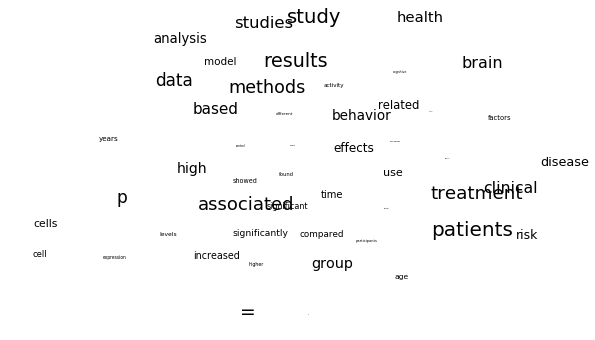

In [24]:
# TSNE Plot
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

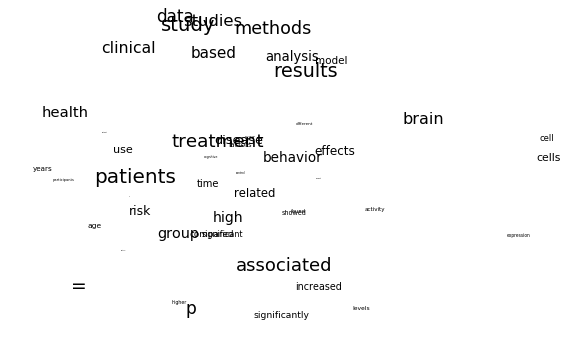

In [25]:
# PCA Plot
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (reducedPCA_data[:, 0][i],reducedPCA_data[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

# Doc2Vec  
Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [26]:
keywords = ['optic', 'brain', 'neural', 'alzheimer', 'parkinson', 'huntington']

In [27]:
pubmed_psyc['tokenized_words'] = pubmed_psyc['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
pubmed_psyc['normalized_words'] = pubmed_psyc['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [28]:
taggedDocs = []
for index, row in pubmed_psyc.iterrows():
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['title'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))

pubmed_psyc['TaggedAbstracts'] = taggedDocs


In [29]:
pubmed_psyc['TaggedAbstracts'][350]

LabeledSentence(words=['purpose', 'computational', 'burden', 'associated', 'model', 'based', 'iterative', 'reconstruction', 'mbir', 'practical', 'limitation', 'iterative', 'coordinate', 'descent', 'icd', 'optimization', 'approach', 'mbir', 'thought', 'incompatible', 'modern', 'computing', 'architectures', 'especially', 'graphics', 'processing', 'units', 'gpus', 'purpose', 'work', 'accelerate', 'previously', 'released', 'open', 'source', 'freect_icd', 'include', 'gpu', 'acceleration', 'demonstrate', 'computational', 'performance', 'icd', 'comparable', 'simultaneous', 'update', 'approaches', 'methods', 'freect_icd', 'uses', 'stored', 'system', 'matrix', 'ssm', 'precalculates', 'forward', 'projector', 'form', 'sparse', 'matrix', 'reconstructs', 'rotating', 'coordinate', 'grid', 'exploit', 'helical', 'symmetry', 'gpu', 'icd', 'implementation', 'shuffle', 'sinogram', 'memory', 'ordering', 'data', 'access', 'sinogram', 'coalesce', 'fewer', 'transactions', 'update', 'ns', 'voxels', 'xy', 'pla

In [30]:
pubmedD2V = gensim.models.doc2vec.Doc2Vec(pubmed_psyc['TaggedAbstracts'], size=100)

//anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [31]:
pubmedD2V['neuron']

array([ 0.45524675,  0.840954  , -0.98568183,  0.04416894,  0.04686768,
        0.04218392, -0.9103407 ,  0.9695072 ,  0.45274857, -0.2822713 ,
       -0.5208335 , -0.14313738, -0.24708807, -0.31637722,  1.0907842 ,
       -0.03423565, -0.18010207,  0.22047614, -0.10918082,  0.22648802,
       -0.71018237, -0.73464304,  0.9903612 , -0.95308715, -0.8008097 ,
       -0.6293125 , -0.23401733,  0.21982934, -0.6672834 ,  0.3492877 ,
       -0.12459791,  0.09965403,  0.4139429 , -0.46619356, -0.37899023,
       -0.8843985 , -0.37104127,  0.48093024, -0.2541008 , -0.28300023,
        0.45569134, -1.0193383 ,  0.39738   , -0.57364684,  0.45042235,
       -0.10028014, -0.40148932, -0.64110714, -0.8431495 ,  0.26439548,
       -0.30222887, -0.8192483 ,  0.55112267,  0.42530644, -0.13378853,
        0.68449014, -0.92408615, -0.10338781, -0.4696574 ,  0.01402848,
        0.8010325 ,  0.37148085,  0.63456243, -0.85825884, -0.47867844,
       -0.67716086, -1.4602855 , -0.42249495,  0.6474962 ,  0.37

In [32]:
pubmedD2V.most_similar(positive=['neuron', 'brain'], negative = ['brain'])

[('pathway', 0.9900926351547241),
 ('dna', 0.9891312718391418),
 ('membrane', 0.9880461692810059),
 ('signaling', 0.9868366718292236),
 ('musk', 0.9848273396492004),
 ('astrocytes', 0.9845941066741943),
 ('selective', 0.9839456677436829),
 ('calcium', 0.9824100136756897),
 ('gpcrs', 0.9804224371910095),
 ('neuronal', 0.9800618886947632)]

In [33]:
pubmedD2V.most_similar(positive=['syndrome', 'disorder'], negative = ['parkinson'])

[('chronic', 0.8974261283874512),
 ('disorders', 0.8827416896820068),
 ('symptoms', 0.8775310516357422),
 ('neurological', 0.8743094801902771),
 ('acute', 0.873618483543396),
 ('severe', 0.8621687889099121),
 ('autism', 0.8367092609405518),
 ('associated', 0.8348663449287415),
 ('spectrum', 0.8271505832672119),
 ('depressive', 0.8209722638130188)]

In [34]:
sklearn.metrics.pairwise.cosine_similarity(pubmedD2V['alzheimer'].reshape(1,-1), pubmedD2V['parkinson'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.99188346]], dtype=float32)

In [35]:
sklearn.metrics.pairwise.cosine_similarity(pubmedD2V['social'].reshape(1,-1), pubmedD2V['neural'].reshape(1,-1))

array([[0.26807004]], dtype=float32)

In [36]:
pubmedD2V.docvecs.most_similar([pubmedD2V['parkinson'] ], topn=5 )

[('Case report on novel mutation in SPAST gene in Polish family with spastic paraplegia.',
  0.9788801670074463),
 ('The Flipside of Eradicating a Disease; Human African Trypanosomiasis in a Woman in Rural Democratic Republic of Congo: A Case Report.',
  0.94810950756073),
 ('Dimethyl Fumarate Was Ineffective but Not Harmful for a Patient with Myelin Oligodendrocyte Glycoprotein Antibody Disease.',
  0.9248144626617432),
 ('Association Between Antidepressant Medication Use and Prevalence and Control of Cardiovascular Risk Factors in Community-Dwelling Older Adults. The Italian Health Examination Survey 2008-2012.',
  0.9200846552848816),
 ('Clinical features of multiple system atrophy with or without rapid eye movement behavior disorder: a cross-sectional study in southwest China.',
  0.9172966480255127)]

Now let's go the other way around and find words most similar to this document:

In [37]:
pubmedD2V.most_similar( [pubmedD2V.docvecs["Cognitive symptoms of Alzheimer's disease: clinical management and prevention."] ], topn=5) 
                                           

[('prodromal', 0.8860006332397461),
 ('parkinson', 0.8843082189559937),
 ('background', 0.883902907371521),
 ('paraneoplastic', 0.8838886022567749),
 ('alzheimer', 0.8796697854995728)]

In [38]:
pubmedD2V.most_similar( [pubmedD2V.docvecs['Cerebrospinal fluid levels of neurogranin in Parkinsonian disorders.'] ], topn=5) 

[('mci', 0.9594337344169617),
 ('age-', 0.9431147575378418),
 ('osa', 0.9399081468582153),
 ('mas', 0.9310817122459412),
 ('controls', 0.9265158176422119)]

We can even look for documents most like a query composed of multiple words:

In [39]:
pubmedD2V.docvecs.most_similar([pubmedD2V['alzheimer']+pubmedD2V['parkinson']+pubmedD2V['huntington']], topn=5 )

[('Case report on novel mutation in SPAST gene in Polish family with spastic paraplegia.',
  0.9704272747039795),
 ('The Flipside of Eradicating a Disease; Human African Trypanosomiasis in a Woman in Rural Democratic Republic of Congo: A Case Report.',
  0.9491209983825684),
 ('Dimethyl Fumarate Was Ineffective but Not Harmful for a Patient with Myelin Oligodendrocyte Glycoprotein Antibody Disease.',
  0.9277753829956055),
 ('Association Between Antidepressant Medication Use and Prevalence and Control of Cardiovascular Risk Factors in Community-Dwelling Older Adults. The Italian Health Examination Survey 2008-2012.',
  0.9156852960586548),
 ('Neurofilament light is a treatment-responsive biomarker in CLN2 disease.',
  0.9117344617843628)]

In [40]:
pubmedD2V.most_similar( [pubmedD2V.docvecs["Age related neurodegenerative Alzheimer's disease: Usage of traditional herbs in therapeutics."] ], topn=5) 

[('management', 0.9406948089599609),
 ('prevention', 0.9341984987258911),
 ('sialorrhoea', 0.9108370542526245),
 ('interventions', 0.9024677276611328),
 ('research', 0.9010812640190125)]

In [41]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = pubmedD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, pubmedD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

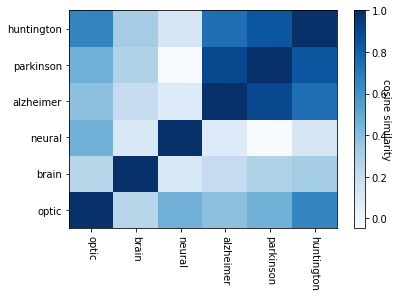

In [42]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='Blues')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

First, we can see the three progressive diseases are closely related and huntington seems to be closely related to optic as well.

In [43]:
# Now let's look at a heatmap of similarities between the first ten documents in the corpus:
targetDocs = pubmed_psyc['title'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = pubmedD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, pubmedD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

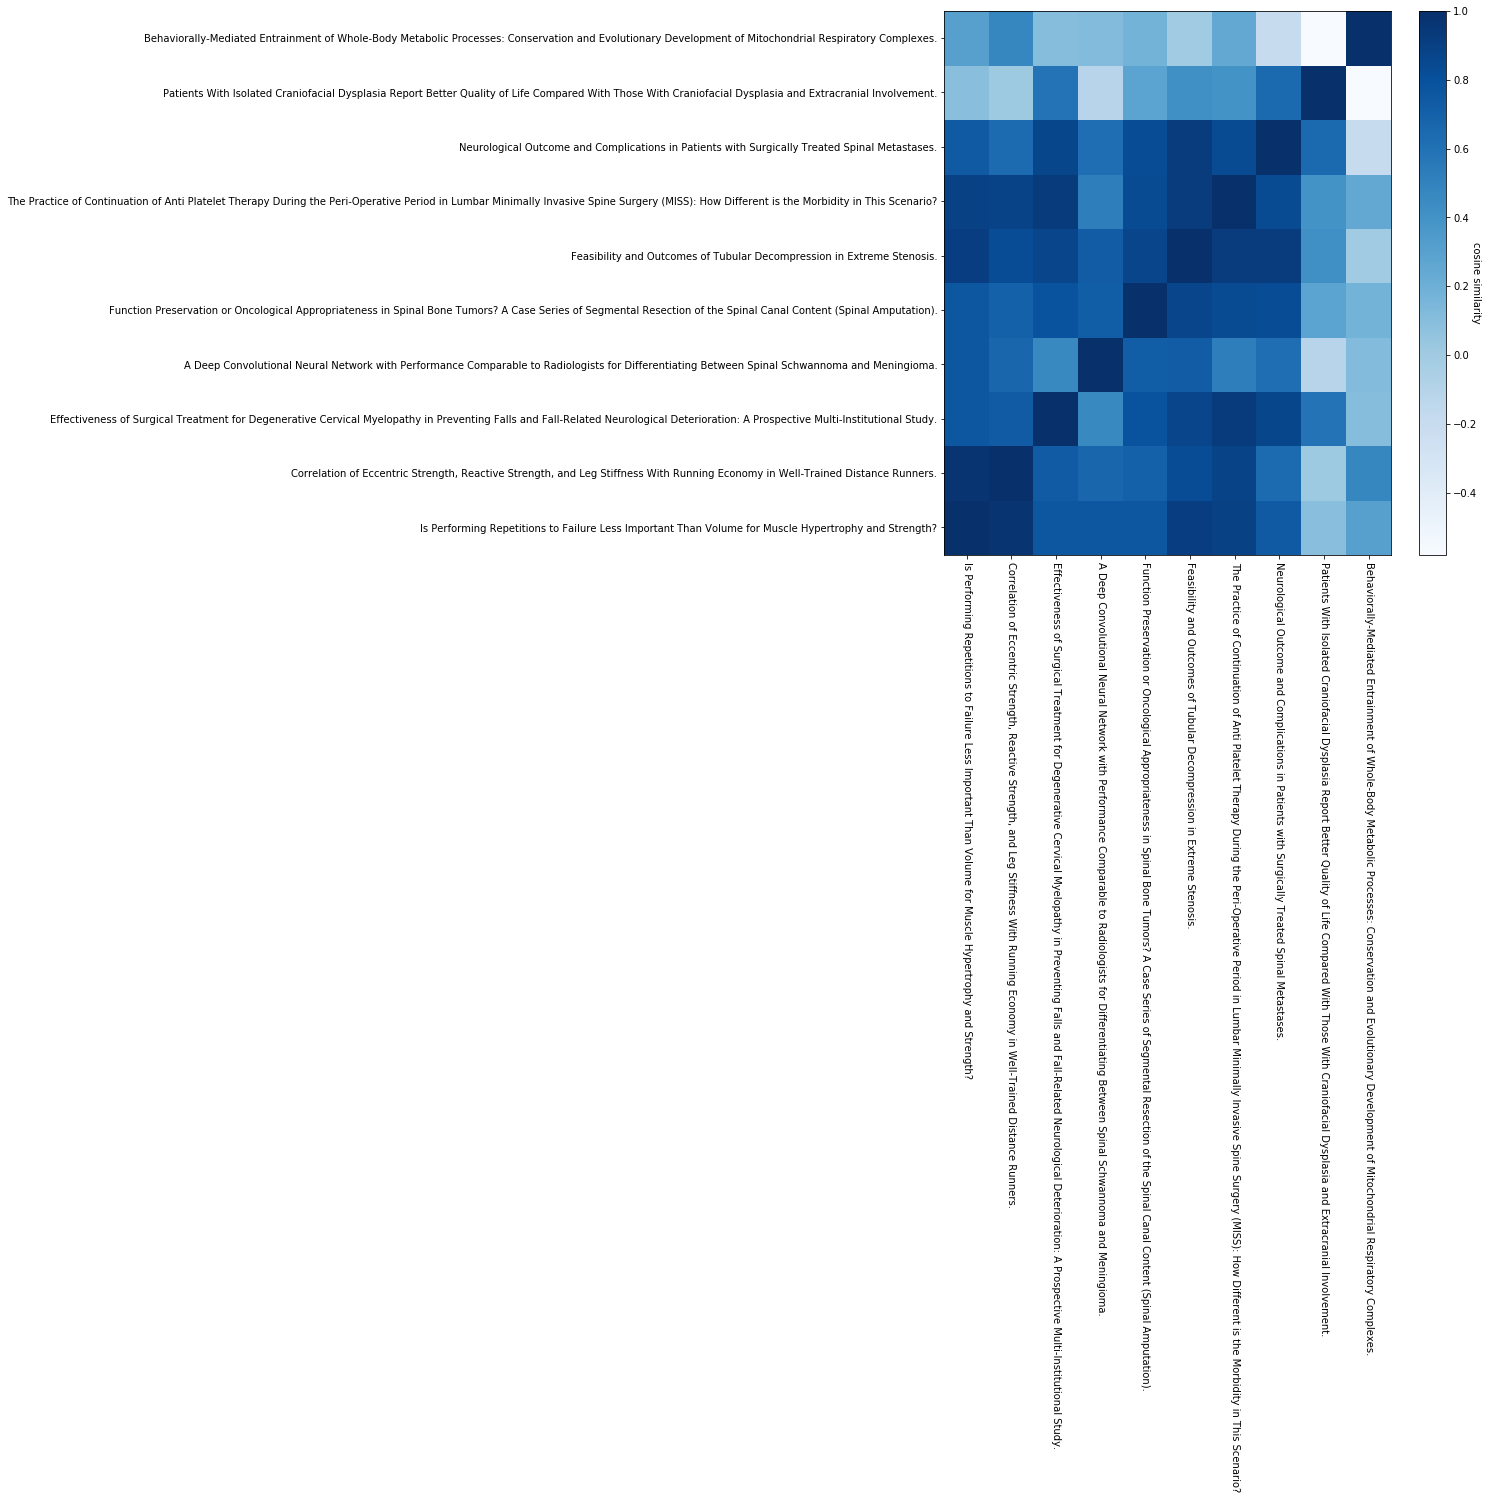

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
hmap = ax.pcolor(heatmapMatrixD, cmap='Blues')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)

a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [55]:
targetWords = ['alzheimer', 'parkinson', 'huntington', 'neurodegenerative', 'age', 'progression', 'memory', 'tremor', 
               'balance', 'cognitive', 'cure', 'medicine', 'treatment']
targetWords += ['depression', 'schizophrenia', 'bipolar', 'personality', 'suicide', 'anxiety', 'agitation','psychotherapy']
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(pubmedW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.27316755,  1.7551286 , -0.62213105, ..., -0.23698969,
         0.37184927, -0.4735749 ],
       [-0.21711802,  1.4910135 , -0.42801893, ..., -0.17620295,
         0.26037526, -0.42299256],
       [-0.05885571,  0.3401101 , -0.114007  , ..., -0.04531337,
         0.07347208, -0.11129963],
       ...,
       [-0.07374486,  1.8035378 ,  0.86673945, ...,  0.37007838,
         0.05053267, -0.17116736],
       [ 0.01930546,  0.11431077,  0.02827392, ...,  0.02906227,
         0.01451551, -0.05054886],
       [-0.08467931,  0.37505344,  0.04878287, ...,  0.05836328,
         0.18309408, -0.12131137]], dtype=float32)

In [56]:
pcaWords = sklearn.decomposition.PCA(n_components = 21).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

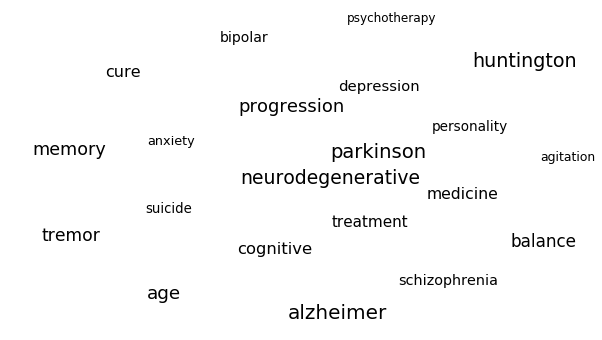

In [57]:
# TSNE Plot
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

In [54]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [59]:
Disease = dimension(pubmedW2V, ['alzheimer', 'parkinson', 'huntington'], ['depression', 'schizophrenia', 'bipolar'])
Symptom = dimension(pubmedW2V, ['memory', 'tremor', 'balance'], ['agitation', 'suicide', 'anxiety'])

In [60]:
Occupations = ['doctor', 'therapist', 'nurse', 'clinician', 'psychiatrist', 'physician', 'neurologist']
Treatments = ['therapy', 'medicine', 'session', 'family', 'empathy', 'drug']

In [62]:
# Define a function to project words in a word list to each of the two dimensions.
def makeDF(model, word_list):
    d = []
    s = []
  
    for word in word_list:
        d.append(sklearn.metrics.pairwise.cosine_similarity(pubmedW2V[word].reshape(1,-1), Disease.reshape(1,-1))[0][0])
        s.append(sklearn.metrics.pairwise.cosine_similarity(pubmedW2V[word].reshape(1,-1), Symptom.reshape(1,-1))[0][0])
        
    df = pandas.DataFrame({'disease': d, 'symptom': s}, index = word_list)
    return df

In [64]:
# get projections
OCCdf = makeDF(pubmedW2V, Occupations) 
Treatdf = makeDF(pubmedW2V, Treatments)

In [65]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

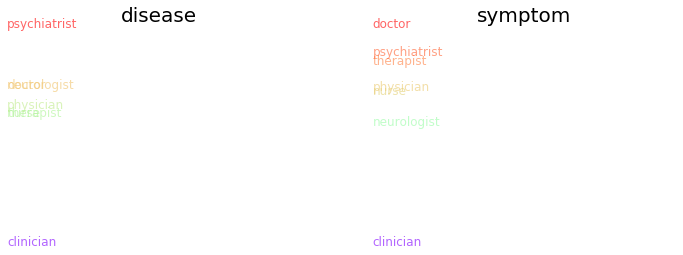

In [66]:
# plot occupation
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
PlotDimension(ax1, OCCdf, 'disease')
ax2 = fig.add_subplot(122)
PlotDimension(ax2, OCCdf, 'symptom')
plt.show()

Interestingly, we distinguish the seemingly similar occupations within the psychology/neural science field. We find that psychiatrist is more closely related to progressive disease such as Parkinson and clinician is more closely related to psychological disorders such as depression. This can suggest that the neural science and psychology studies research on unconventional ways of treating these two kinds of diseases. 

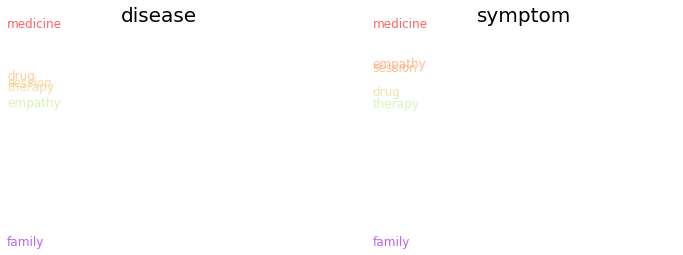

In [67]:
# plot treatment
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
PlotDimension(ax1, Treatdf, 'disease')
ax2 = fig.add_subplot(122)
PlotDimension(ax2, Treatdf, 'symptom')
plt.show()

In discovering how treatments are projected on these two kinds of diseases, we notice that medicine is most closely related with Alzheimer, Parkinson and Huntington diseases, showing an increasing effort in experimenting medicines in this field, but psychological disorders lack this type of treatment. Instead, family, empathy and therapy are most closely related with depression, schizophrenia and bipolar, suggesting that scientists lean toward a psychological way of treatment instead of medicine.

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

Due to the size of the data and the computation load, I selected year 1979, 1991, 2017, 2018 and 2019.

In [77]:
filename = 'pubmed20n0060.xml.gz'
psych_keywords = ['psych', 'behavior', 'neur']

def isPsych(abstract, keywords):
    return any(word in abstract for word in keywords)

pubmed_parsed = pp.parse_medline_xml("./" + filename)
pubmed_df = pd.DataFrame(pubmed_parsed)
pubmed_norm = pd.DataFrame(index=pubmed_df.index, columns=['flag_psych'], dtype=object)
for row in pubmed_df.itertuples():
    #flag pschology articles
    pubmed_norm.at[row.Index, 'flag_psych'] = isPsych(row.abstract + row.title, psych_keywords)
pubmed_full = pd.concat([pubmed_df, pubmed_norm], axis = 1)
pubmed_psyc1 = pubmed_full[pubmed_full['flag_psych']].reset_index()


In [78]:
pubmed_psyc1['tokenized_sents'] = pubmed_psyc1['abstract'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
pubmed_psyc1['normalized_sents'] = pubmed_psyc1['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

In [79]:
pubmed_psyc1['tokenized_words'] = pubmed_psyc1['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
pubmed_psyc1['normalized_words'] = pubmed_psyc1['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [103]:
filename = 'pubmed20n0015.xml.gz'
psych_keywords = ['psych', 'behavior', 'neur']

def isPsych(abstract, keywords):
    return any(word in abstract for word in keywords)

pubmed_parsed = pp.parse_medline_xml("./" + filename)
pubmed_df = pd.DataFrame(pubmed_parsed)
pubmed_norm = pd.DataFrame(index=pubmed_df.index, columns=['flag_psych'], dtype=object)
for row in pubmed_df.itertuples():
    #flag pschology articles
    pubmed_norm.at[row.Index, 'flag_psych'] = isPsych(row.abstract + row.title, psych_keywords)
pubmed_full = pd.concat([pubmed_df, pubmed_norm], axis = 1)
pubmed_psyc2 = pubmed_full[pubmed_full['flag_psych']].reset_index()


In [104]:
pubmed_psyc2['tokenized_sents'] = pubmed_psyc2['abstract'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
pubmed_psyc2['normalized_sents'] = pubmed_psyc2['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

In [105]:
pubmed_psyc2['tokenized_words'] = pubmed_psyc2['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
pubmed_psyc2['normalized_words'] = pubmed_psyc2['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [123]:
filename = 'pubmed20n0922.xml.gz'
psych_keywords = ['psych', 'behavior', 'neur']

def isPsych(abstract, keywords):
    return any(word in abstract for word in keywords)

pubmed_parsed = pp.parse_medline_xml("./" + filename)
pubmed_df = pd.DataFrame(pubmed_parsed)
pubmed_norm = pd.DataFrame(index=pubmed_df.index, columns=['flag_psych'], dtype=object)
for row in pubmed_df.itertuples():
    #flag pschology articles
    pubmed_norm.at[row.Index, 'flag_psych'] = isPsych(row.abstract + row.title, psych_keywords)
pubmed_full = pd.concat([pubmed_df, pubmed_norm], axis = 1)
pubmed_psyc3 = pubmed_full[pubmed_full['flag_psych']].reset_index()


In [124]:
pubmed_psyc3['tokenized_sents'] = pubmed_psyc3['abstract'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
pubmed_psyc3['normalized_sents'] = pubmed_psyc3['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

In [125]:
pubmed_psyc3['tokenized_words'] = pubmed_psyc3['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
pubmed_psyc3['normalized_words'] = pubmed_psyc3['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [126]:
pubmed_psyc_comb = pd.concat([pubmed_psyc, pubmed_psyc1, pubmed_psyc2, pubmed_psyc3])

In [127]:
# check the years of these studies
pubmed_psyc_comb.pubdate.value_counts()

2019    4438
1991    2870
1979    2147
2017     831
2018     397
        ... 
1978       1
1895       1
2010       1
1883       1
1891       1
Name: pubdate, Length: 65, dtype: int64

In [128]:
# select from the target years
targetYear = ['2019', '1991', '1979', '2018', '2017']
pubmed_psyc_years = pubmed_psyc_comb[pubmed_psyc_comb['pubdate'].isin(targetYear)]

In [69]:
import copy

In [70]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab
    
    return (m1,m2)

In [71]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

In [129]:
rawEmbeddings, comparedEmbeddings = compareModels(pubmed_psyc_years, 'pubdate')

In [130]:
rawEmbeddings.keys()

dict_keys(['1979', '1991', '2017', '2018', '2019'])

In [131]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

depression


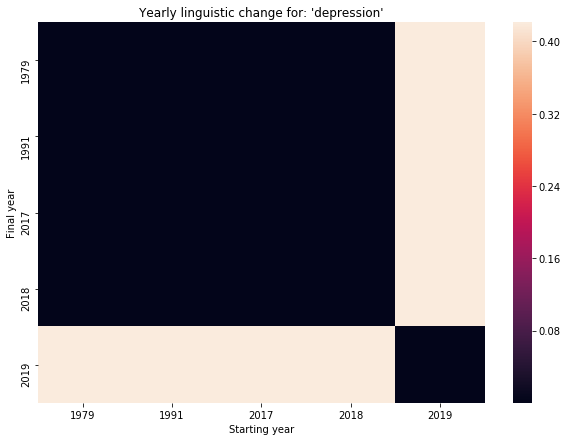

In [132]:
targetWord = 'depression'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [114]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [134]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 1619 words to compare


The most divergent words are:

In [135]:
wordDivergences[:20]

[('mg', 0.9450452327728271),
 ('=', 0.9196750223636627),
 ('kg', 0.9054460525512695),
 ('n', 0.8841544389724731),
 ('p', 0.7191071808338165),
 ('system', 0.6636738181114197),
 ('group', 0.663146436214447),
 ('nervous', 0.6027410626411438),
 ('cell', 0.5881864428520203),
 ('analysis', 0.5819232165813446),
 ('+', 0.5793361663818359),
 ('cells', 0.577818751335144),
 ('rats', 0.5761454105377197),
 ('day', 0.5712363123893738),
 ('disease', 0.5698440372943878),
 ('studies', 0.5642511546611786),
 ('cancer', 0.5584787130355835),
 ('age', 0.5575647354125977),
 ('long', 0.5545349419116974),
 ('days', 0.5539077520370483)]

The least divergent words are:

In [136]:
wordDivergences[-20:]

[('led', 0.022906601428985596),
 ('products', 0.0226670503616333),
 ('substantial', 0.02259206771850586),
 ('example', 0.0222284197807312),
 ('attributed', 0.021842598915100098),
 ('variability', 0.02151423692703247),
 ('appear', 0.02133733034133911),
 ('joint', 0.021084487438201904),
 ('explained', 0.01958709955215454),
 ('depending', 0.01937311887741089),
 ('rarely', 0.018023669719696045),
 ('sufficient', 0.01793903112411499),
 ('defined', 0.01779043674468994),
 ('appears', 0.016987740993499756),
 ('appeared', 0.016909122467041016),
 ('contact', 0.01683628559112549),
 ('respect', 0.01620960235595703),
 ('regardless', 0.01520991325378418),
 ('sense', 0.014138877391815186),
 ('extent', 0.013745784759521484)]

alzheimer


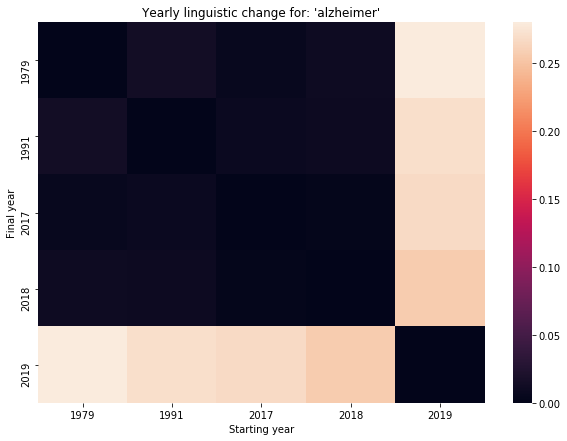

In [137]:
targetWord = 'alzheimer'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

therapy


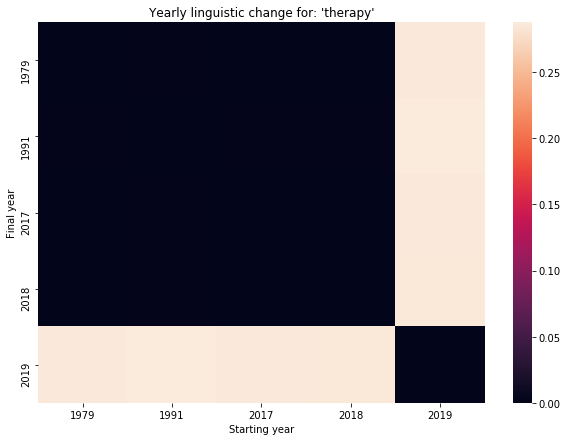

In [138]:
targetWord = 'therapy'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

dopamine


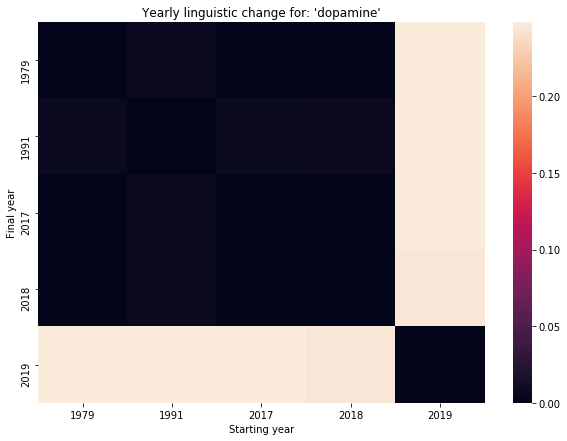

In [139]:
targetWord = 'dopamine'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

From observing the linguistic change overtime for different words, we can see that there is a high consistency from 1979 to 2018, and a big divergence between these years with 2019. This could mean that the topics, methods and significant progress has been made in 2019 so that words carry different meanings in 2019. Whether it marked a paradigm shift or simply a different writing style in 2019 deserves further investigation.